In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Extract Dataset

In [2]:
dataset = './Dataset'
bahan_makanan = ['Bawang Bombai', 'Daging Ayam', 'Daging Sapi', 'Daun Bawang', 'Kubis Merah', 'Telur', 'Terong', 'Timun', 'Tomat', 'Wortel']

In [3]:
bahan_makanan_data = []

for bahan in bahan_makanan:
    bahan = os.path.join(dataset, bahan)
    bahan_makanan_data.append(bahan)

In [4]:
bahan_makanan_data

['./Dataset\\Bawang Bombai',
 './Dataset\\Daging Ayam',
 './Dataset\\Daging Sapi',
 './Dataset\\Daun Bawang',
 './Dataset\\Kubis Merah',
 './Dataset\\Telur',
 './Dataset\\Terong',
 './Dataset\\Timun',
 './Dataset\\Tomat',
 './Dataset\\Wortel']

In [5]:
jumlah_bahan = []

for bahan in bahan_makanan_data:
    jumlah = len(os.listdir(bahan))
    jumlah_bahan.append(jumlah)

In [6]:
# for i, bahan in enumerate(bahan_makanan_data):
#     nama_bahan = bahan_makanan[i]
#     print(f"{len(os.listdir(bahan))} gambar {nama_bahan}.")

# EDA

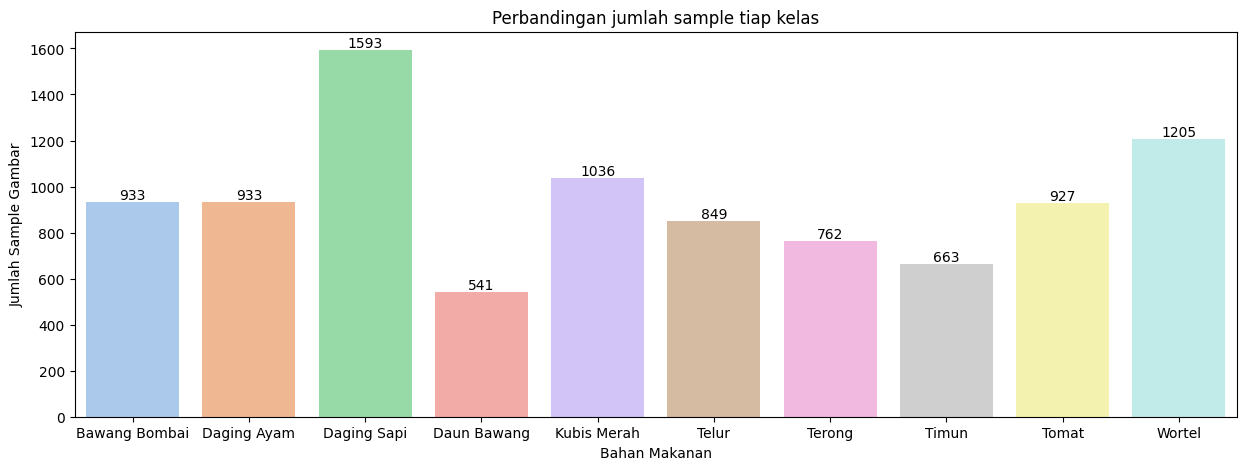

In [7]:
plt.figure(figsize = (15, 5))

chart = sns.barplot(x = bahan_makanan, y = jumlah_bahan, palette = 'pastel', hue = bahan_makanan)
for container in chart.containers:
    chart.bar_label(container, fontsize=10)
    
plt.title('Perbandingan jumlah sample tiap kelas')
plt.xlabel("Bahan Makanan")
plt.ylabel("Jumlah Sample Gambar")
plt.show()

# Split Dataset (train, val, test)

In [8]:
train_set = tf.keras.utils.image_dataset_from_directory(
    directory = dataset,
    image_size = (224, 224),
    label_mode = 'categorical',
    validation_split = 0.2,
    batch_size = 32, 
    subset = 'training',
    seed = 42
)

val_train_set = tf.keras.utils.image_dataset_from_directory(
    directory = dataset,
    image_size = (224, 224),
    label_mode = 'categorical',
    validation_split = 0.2,
    batch_size = 32,
    subset = 'validation',
    seed = 42
)

Found 9442 files belonging to 10 classes.
Using 7554 files for training.
Found 9442 files belonging to 10 classes.
Using 1888 files for validation.


In [9]:
validation_size = int(0.5 * len(val_train_set))
test_size = len(val_train_set) - validation_size

val_set = val_train_set.take(validation_size)
test_set = val_train_set.skip(validation_size)

# Transform Dataset

In [10]:
augmentation_model = tf.keras.Sequential([ 
    tf.keras.Input(shape = (224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2, fill_mode = 'nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode = 'nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode = 'nearest')
])  

train_set = train_set.map(lambda x, y: (augmentation_model(x), y))

In [12]:
# Train Dataset
train_set = train_set.shuffle(buffer_size=1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation Dataset
val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test Dataset
test_set = test_set.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training dataset size: {len(train_set)} batches")
print(f"Validation dataset size: {len(val_set)} batches")
print(f"Test dataset size: {len(test_set)} batches")

Training dataset size: 237 batches
Validation dataset size: 29 batches
Test dataset size: 30 batches


In [13]:
for images, labels in train_set.take(1):  
    print("Shape of images:", images.shape)      
    print("Shape of labels:", labels.shape)      

Shape of images: (32, 224, 224, 3)
Shape of labels: (32, 10)


# Calling the Pre-Trained Model (MobileNetV2)

In [14]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

In [15]:
for layer in base_model.layers:
  layer.trainable = False

# Create the Model

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.Flatten(),
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compiling The Model

In [19]:
optimizer = tf.optimizers.Adam()

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy', 'f1_score']
    
)

# Training The Model

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',  
    patience = 5,              
    restore_best_weights = True  
)

In [21]:
history = model.fit(
    train_set,
    validation_data = val_set,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 230s 936ms/step - accuracy: 0.8313 - f1_score: 0.8250 - loss: 1.6964 - val_accuracy: 0.9181 - val_f1_score: 0.8829 - val_loss: 2.5123
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 212s 893ms/step - accuracy: 0.9728 - f1_score: 0.9709 - loss: 0.3596 - val_accuracy: 0.9731 - val_f1_score: 0.9717 - val_loss: 0.8877
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 212s 895ms/step - accuracy: 0.9784 - f1_score: 0.9785 - loss: 0.2858 - val_accuracy: 0.9795 - val_f1_score: 0.9797 - val_loss: 0.6911
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 212s 893ms/step - accuracy: 0.9893 - f1_score: 0.9903 - loss: 0.1227 - val_accuracy: 0.9806 - val_f1_score: 0.9819 - val_loss: 0.7218
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 219s 924ms/step - accuracy: 0.9916 - f1_score: 0.9916 - loss: 0.1154 - val_accuracy: 0.9795 - val_f1_score: 0.9795 - val_loss: 0.9531
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 208s 876ms/step - accuracy: 0.9916 - f1_score: 0.9920 - loss: 0.1361 - val_accuracy:

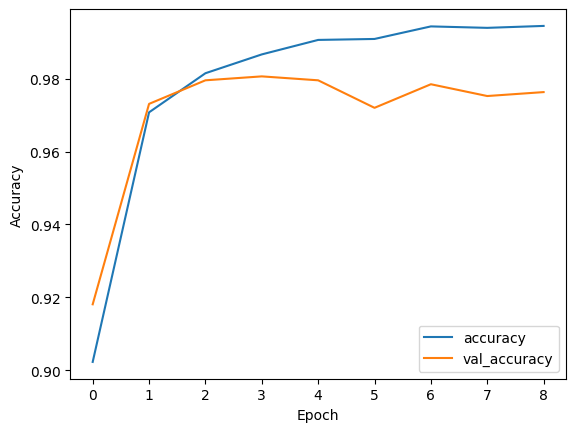

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Evaluate The Model with Unseen Data (Test Set)

In [24]:
model.evaluate(test_set)

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - accuracy: 0.9894 - f1_score: 0.9873 - loss: 0.2291


[0.2600725293159485,
 0.9895833134651184,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.99470896, 0.95876276, 0.98316497, 1.        , 0.9952606 ,
        1.        , 0.9940828 , 1.        , 1.        , 0.9816513 ],
       dtype=float32)>]

# Model 2

In [27]:
# model_2 = tf.keras.models.Sequential([
#     augmentation_layers,
#     base_model,
#     tf.keras.layers.Rescaling(1./255),
#     tf.keras.layers.Flatten(),
#     #tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation = 'softmax')
# ])